In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import networkx as nx 
import osmnx as ox 
import numpy as np 
import seaborn as sns 
import pandas as pd
import networkx as nx
from shapely.geometry import Point, LineString
import pickle
import matplotlib.pyplot as plt
import folium
import pandas as pd
import networkx as nx
from shapely.geometry import Point, LineString
import pickle
from tqdm import tqdm 
import os
import warnings
os.environ['USE_PYGEOS']='0'

# Display all columns in the df
pd.set_option('display.max_columns', None)
# Set the float format to display numbers in standard decimal notation
pd.options.display.float_format = '{:.5f}'.format
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

pd.set_option('display.max_columns', None)

In [7]:
# Read in the road network graph

with open(r"/Users/antonglad/Master/pc/Pickle/BaseGraph0_3NOR_wagrades.pickle", 'rb') as file:
    G = pickle.load(file)

In [8]:
# create a dictionary mapping node IDs to (x, y) coordinates
node_coords = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

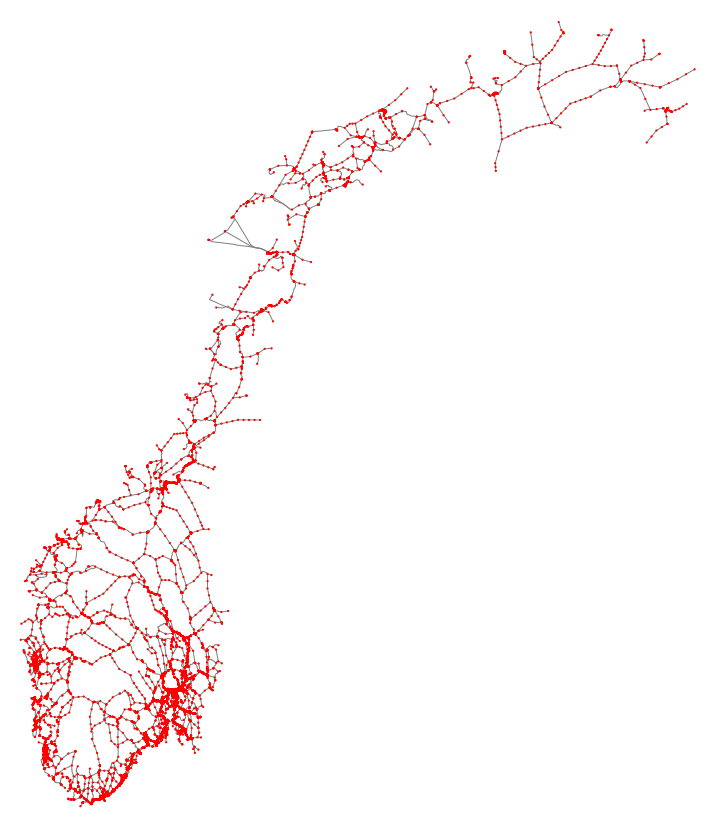

(<Figure size 2160x1080 with 1 Axes>, <AxesSubplot: >)

In [9]:
#Plot Graph

ox.plot_graph(G, figsize = (30, 15), node_color="red", edge_color = "gray", bgcolor = "white", node_size=5, edge_linewidth = 1)

In [10]:
# Create an empty dataframe to store node attributes
node_df = pd.DataFrame(columns=['node', "osmid", "latitude", "longitude", 'gradient', "isBridge", "isTunnel", "roadclass", "geometry"])

# Iterate over all nodes in the network
# Note: Generates a lot of output - clear cell output after the code has run - must be a better way to this 
for node in G.nodes:
    # Get the gradient attribute of the node and add it to the dataframe
    osmid = G.nodes[node]["osmid"]
    lat = G.nodes[node]["x"]
    lon = G.nodes[node]["y"]
    isBridge = G.nodes[node]["isBridge"]
    isTunnel = G.nodes[node]["isTunnel"]
    roadclass = G.nodes[node]["roadclass"]
    gradient = G.nodes[node]['elevation']
    geo = G.nodes[node]["geometry"]

    node_df = node_df.append({"osmid": osmid, 'node': node, "latitude": lon, "longitude": lat, 'gradient': gradient, "isBridge": isBridge, "isTunnel": isTunnel, "roadclass": roadclass, "geometry": geo}, ignore_index=True)

In [11]:
# Convert the edge data to a pandas DataFrame
edge_data = G.edges(data=True)
edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
edge_df = pd.concat([edge_df.drop('data_dict', axis=1), edge_df['data_dict'].apply(pd.Series)], axis=1)

In [12]:
# Convert the dataframes to geodataframes, using the "geometry" column as the geometry
edge_gdf = gpd.GeoDataFrame(edge_df, geometry="geometry")
node_gdf = gpd.GeoDataFrame(node_df, geometry="geometry")

To many nodes on the same locations...


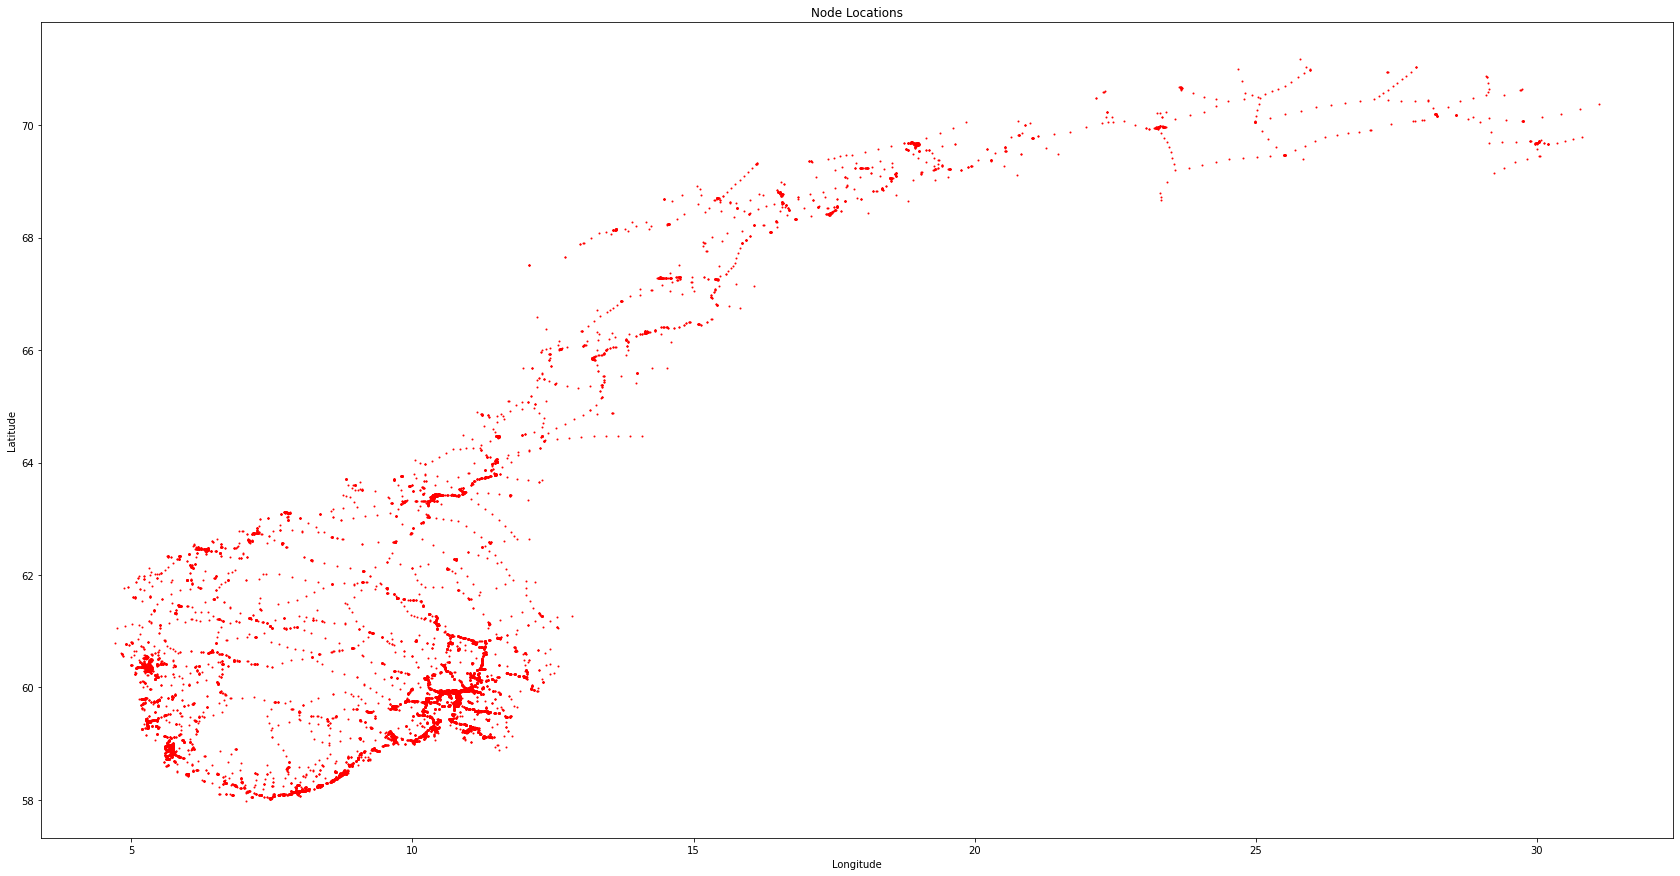

In [13]:
import matplotlib.pyplot as plt

# Create a scatter plot of the node locations
fig, ax = plt.subplots(figsize=(30, 15))
node_gdf.plot(ax=ax, markersize=1, color = 'red')

# Add a title and axis labels
ax.set_title("Node Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("To many nodes on the same locations...")
# Display the plot
plt.show()

In [14]:
# Import Traffic Counts:
# Load volume dataset
csv_pd=pd.read_excel(r"/Users/antonglad/Master/pc/Pickle/all_roads_volume.xlsx")
# csv_pd.drop(columns='Unnamed: 0', inplace=True)
csv_pd.head(3)

,id,name,lat,lon,volume,year,month,heading1,volume_heading1,heading2,volume_heading2
0,65823V1668921,FJØSDALEN,67.98167,13.17546,469,2018,1,Leknes,235.00000,Reine,234.00000
1,65823V1668921,FJØSDALEN,67.98167,13.17546,706,2018,2,Leknes,353.00000,Reine,352.00000
2,65823V1668921,FJØSDALEN,67.98167,13.17546,760,2018,3,Leknes,381.00000,Reine,379.00000


In [15]:
#Removing all duaplicates, in this case we only need one observation per registration point to visualize

csv_pd_woDup = csv_pd.copy().drop_duplicates('id').reset_index(drop=True)
csv_pd_woDup.head(3)

,id,name,lat,lon,volume,year,month,heading1,volume_heading1,heading2,volume_heading2
0,65823V1668921,FJØSDALEN,67.98167,13.17546,469,2018,1,Leknes,235.00000,Reine,234.00000
1,00185V249528,Lønset,62.76024,7.37004,5122,2018,1,Molde,2567.00000,Hjelset,2555.00000
2,80360V72241,Mannsfjelltunnelen,63.32030,10.12739,9606,2018,1,Trondheim,4833.00000,Orkanger,4773.00000


In [16]:
# Remove volume1 and volume2

csv_pd_woDup['geometry'] = csv_pd_woDup.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
csv_pd_woDup.head(3)

,id,name,lat,lon,volume,year,month,heading1,volume_heading1,heading2,volume_heading2,geometry
0,65823V1668921,FJØSDALEN,67.98167,13.17546,469,2018,1,Leknes,235.00000,Reine,234.00000,POINT (13.175464 67.98167)
1,00185V249528,Lønset,62.76024,7.37004,5122,2018,1,Molde,2567.00000,Hjelset,2555.00000,POINT (7.370038 62.760245)
2,80360V72241,Mannsfjelltunnelen,63.32030,10.12739,9606,2018,1,Trondheim,4833.00000,Orkanger,4773.00000,POINT (10.127395 63.320305)


In [17]:
traffic_counts = gpd.GeoDataFrame(csv_pd_woDup, geometry="geometry")
points_df = traffic_counts.copy()
traffic_counts.head(3)

,id,name,lat,lon,volume,year,month,heading1,volume_heading1,heading2,volume_heading2,geometry
0,65823V1668921,FJØSDALEN,67.98167,13.17546,469,2018,1,Leknes,235.00000,Reine,234.00000,POINT (13.17546 67.98167)
1,00185V249528,Lønset,62.76024,7.37004,5122,2018,1,Molde,2567.00000,Hjelset,2555.00000,POINT (7.37004 62.76024)
2,80360V72241,Mannsfjelltunnelen,63.32030,10.12739,9606,2018,1,Trondheim,4833.00000,Orkanger,4773.00000,POINT (10.12739 63.32030)


In [18]:
print(traffic_counts.dtypes)

id                   object
name                 object
lat                 float64
lon                 float64
volume                int64
year                  int64
month                 int64
heading1             object
volume_heading1     float64
heading2             object
volume_heading2     float64
geometry           geometry
dtype: object


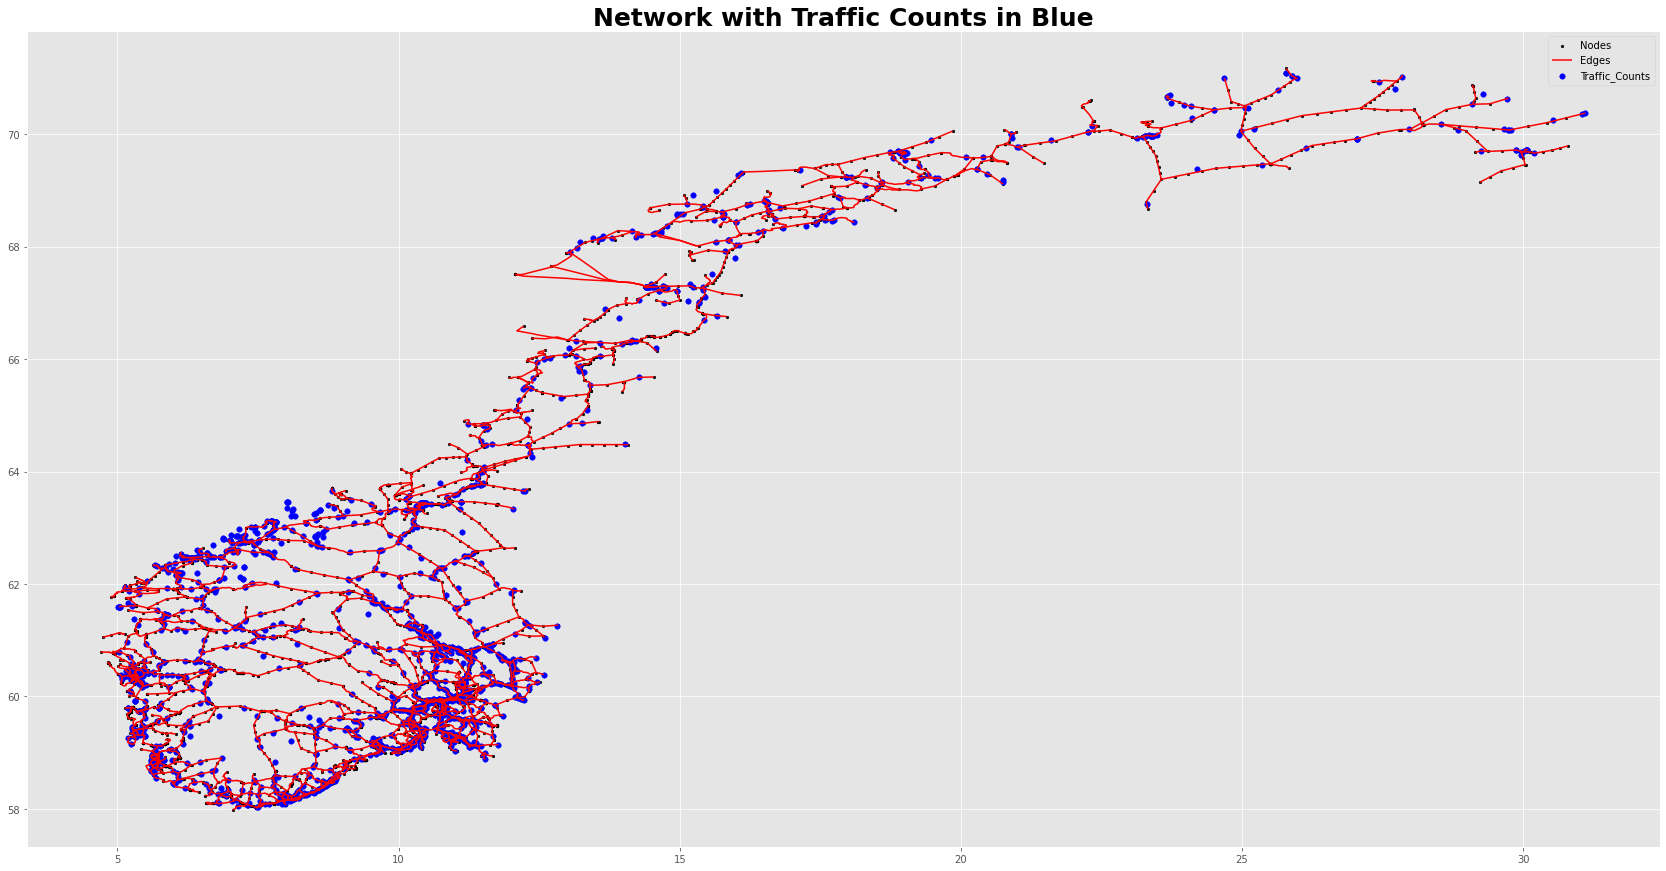

In [19]:
# set style to default
plt.style.use('ggplot')

# set up the plot
fig, ax = plt.subplots(figsize=(30, 15))

node_gdf.plot(ax=ax, color='black', markersize=7)
edge_gdf.plot(ax=ax, color='red')
traffic_counts.plot(ax=ax, color='blue', markersize=30)
ax.legend(['Nodes', 'Edges', 'Traffic_Counts'])
ax.set_title('Network with Traffic Counts in Blue', fontweight='bold', fontsize=25)

# display the plot
plt.show()

*Next cell takes a long time to run (10+ hours), not feasible:*

In [ ]:
import osmnx as ox
from shapely.geometry import Point
from tqdm import tqdm

# Minimum distance threshold
min_distance = 1000

def points_far_from_edges(traffic_counts, graph, min_distance):
    far_points = []

    # Project the graph to UTM CRS
    graph_proj = ox.project_graph(graph)

    for _, row in tqdm(traffic_counts.iterrows(), total=traffic_counts.shape[0]):
        point_id = row["id"]
        point = row['geometry']
        lat, lon = point.y, point.x

        # Find the nearest edge
        nearest_edge = ox.distance.nearest_edges(graph_proj, X=lat, Y=lon, return_dist=True)
        edge, distance = nearest_edge[0], nearest_edge[1]

        # Check if the distance is greater than or equal to the minimum distance
        if distance >= min_distance:
            far_points.append(point_id)

    return far_points

result = points_far_from_edges(traffic_counts, G, min_distance)
print("Points not within the minimum distance from edges:", result)


In [ ]:
amount=0
for i in result:
    if i:
        amount+=1

print(amount)


In [ ]:
# Create a folium map object centered on the first node in the node geodataframe
map_obj = folium.Map(location=[node_gdf.geometry.iloc[0].y, node_gdf.geometry.iloc[0].x], zoom_start=10)

# Create a feature group for the edges
edge_fg = folium.FeatureGroup(name="Edges")

# Add each edge as a line to the feature group, with a popup displaying the edge weight
for i, row in edge_gdf.iterrows():
    popup_str = f"Source: {row['source']}<br>Target: {row['target']}<br>Edge ID: {row['geometry']}"
    folium.PolyLine(locations=[(row.geometry.coords[0][1], row.geometry.coords[0][0]),
                                (row.geometry.coords[1][1], row.geometry.coords[1][0])],
                    popup=popup_str,
                    tooltip=f"Edge ({row['source']}, {row['target']})").add_to(edge_fg)

# Add the edge feature group to the map
edge_fg.add_to(map_obj)

# Add a layer control to the map, allowing the user to toggle the visibility of the edge and node feature groups
folium.LayerControl().add_to(map_obj)

# Display the map
map_obj

In [23]:
import folium
import networkx as nx

# Create a folium map centered on the first point in points_df
m = folium.Map(location=[points_df.iloc[0]['lat'], points_df.iloc[0]['lon']], zoom_start=10)


# Add the points to the map
for _, row in points_df.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup=(row['name'], row['id'])).add_to(m)

# Display the map
m


In [25]:
import plotly.graph_objs as go

# Create the map trace
map_trace = go.Scattermapbox(
    lat=points_df['lat'],
    lon=points_df['lon'],
    mode='markers',
    marker=dict(size=10, color='blue'),
    text=points_df['name'],
    hovertemplate="%{text}<br>Id: %{id}<br>Latitude: %{lat:.2f}<br>Longitude: %{lon:.2f}<extra></extra>",
    customdata=points_df['id']
)

# Create the graph trace
graph_trace = go.Bar(
    x=points_df['name'],
    y=points_df['volume'],
    marker=dict(color='green'),
    hovertemplate="%{x}<br>Volume: %{y}<extra></extra>"
)

# Create the subplot figure
fig = go.Figure(
    data=[map_trace, graph_trace],
    layout=go.Layout(
        title='Map and Volume Bar Chart',
        grid=dict(rows=1, columns=2),
        mapbox=dict(
            center=dict(lat=points_df['lat'].mean(), lon=points_df['lon'].mean()),
            zoom=10,
            style='open-street-map'
        ),
        xaxis=dict(title='Point Name'),
        yaxis=dict(title='Volume')
    )
)

# Display the subplot
fig.show()


In [ ]:
import mplleaflet

# set style to default
plt.style.use('ggplot')

# set up the plot
fig, ax = plt.subplots(figsize=(30, 15))

node_gdf.plot(ax=ax, color='black', markersize=7)
edge_gdf.plot(ax=ax, color='red')
traffic_counts.plot(ax=ax, color='blue', markersize=30)
ax.legend(['Nodes', 'Edges', 'Traffic_Counts'])
ax.set_title('Network with Traffic Counts in Blue', fontweight='bold', fontsize=25)

# convert the plot to an interactive map
mplleaflet.show(fig=fig)


In [28]:
import plotly.graph_objs as go
import plotly.offline as pyo
import mplleaflet

# Create the map trace
map_trace = go.Scattermapbox(
    lat=points_df['lat'],
    lon=points_df['lon'],
    mode='markers',
    marker=dict(size=10, color='blue'),
    text=points_df['name'],
    hovertemplate="%{text}<br>Id: %{customdata}<br>Latitude: %{lat:.2f}<br>Longitude: %{lon:.2f}<extra></extra>",
    customdata=points_df['id'],
    hoverinfo='text+name',
    meta=points_df['id']
)

# Create the graph trace
graph_trace = go.Bar(
    x=points_df['lat'],
    y=points_df['lon'],
    marker=dict(color='green'),
    hovertemplate="%{x}<br>Volume: %{y}<extra></extra>",
    xaxis= None,
    yaxis= None
)

# Create the subplot figure
fig = go.Figure(
    data=[map_trace, graph_trace],
    layout=go.Layout(
        title='Map and Volume Bar Chart',
        grid=dict(rows=1, columns=2),
        hovermode='x unified',  # set hovermode to x unified
        mapbox=dict(
            center=dict(lat=points_df['lat'].mean(), lon=points_df['lon'].mean()),
            zoom=10,
            style='open-street-map'
    ),
    xaxis=dict(title='Latitude'),
    yaxis=dict(title='Longitude'),
    width= 2300
)
)

# Display the subplot
fig.show()

# Save the plot as an HTML file
pyo.plot(fig, filename='map.html')


'map.html'

In [29]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource, HoverTool, Panel, Tabs
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.layouts import column
from bokeh.models import CustomJS



# Convert latitude and longitude to Web Mercator coordinates
def wgs84_to_web_mercator(df, lon, lat):
    k = 6378137
    df["x"] = df[lon] * (k * np.pi / 180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi / 360.0)) * k
    return df
    
# Drop the geometry column
points_df = points_df.drop(columns=['geometry'])
# Convert points_df coordinates to Web Mercator
points_df_mercator = wgs84_to_web_mercator(points_df, 'lon', 'lat')

# Create a ColumnDataSource from the DataFrame
source = ColumnDataSource(points_df_mercator)

# Initialize the map with a tile provider
tile_provider = get_provider(Vendors.CARTODBPOSITRON)
map_plot = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
                  x_axis_type="mercator", y_axis_type="mercator",
                  title="Map")
map_plot.add_tile(tile_provider)

# Add circle glyphs to the map
map_plot.circle(x='x', y='y', source=source, size=10, color='blue')

# Create a hover tool for the map
map_hover = HoverTool(tooltips=[
    ("Name", "@name"),
    ("ID", "@id"),
    ("Latitude", "@lat{0.2f}"),
    ("Longitude", "@lon{0.2f}")
])
map_plot.add_tools(map_hover)

info_div = Div(text="", width=800, height=50)

callback = CustomJS(args=dict(source=source, div=info_div), code="""
    const indices = source.selected.indices;
    if (indices.length > 0) {
        const index = indices[0];
        const name = source.data['name'][index];
        const id = source.data['id'][index];
        const lat = source.data['lat'][index];
        const lon = source.data['lon'][index];
        div.text = `Name: ${name}<br>ID: ${id}<br>Latitude: ${lat.toFixed(2)}<br>Longitude: ${lon.toFixed(2)}`;
    } else {
        div.text = "";
    }
""")

map_plot.circle(x='x', y='y', source=source, size=10, color='blue', js_event_callbacks={'tap': [callback]})


# Create the bar chart
bar_plot = figure(title="Volume Bar Chart", x_axis_label="Latitude", y_axis_label="Longitude")
bar_plot.vbar(x='lat', top='lon', source=source, width=0.1, color='green')

# Create a hover tool for the bar chart
bar_hover = HoverTool(tooltips=[
    ("Latitude", "@lat"),
    ("Volume", "@lon")
])
bar_plot.add_tools(bar_hover)

# Create a grid layout with the map and bar chart
grid = gridplot([[map_plot, bar_plot]])
layout = column(grid, info_div)
show(layout)


# Save the output to an HTML file
output_file("map_and_volume_chart.html")
show(grid)
